In [1]:
!pip install jsonpath-ng requests ipyplot tifffile --default-timeout=100

In [2]:
import json
import requests
import urllib.request
import jsonpath_ng 
import ipyplot
import io
from jsonpath_ng import jsonpath
from jsonpath_ng.ext import parse
from IPython.display import display, Markdown
from PIL import Image, ImageColor
from contextlib import closing
from numpy import asarray

### Get Study

In [3]:
def get_ftp_path(accession):
    '''
    To avoid slowing down of directory listing operations, the FTP path for each study is 
    structured as a first level directory which is generally the accession prefix without any numbers 
     and then a second level directory which is last three zero padded digits (000 if the last character 
    is not a digit, e.g., S-BIAD would be under the relative path S-BIAD/007/S-BIAD7
    '''
    prefix = accession.rstrip('0123456789')
    number = accession.replace(prefix, '')
    number = int(number)%1000 if number.isdigit() else 0    
    return '{prefix}/{number:03d}/{accession}'.format( prefix=prefix, number=number, accession=accession)

def display_attributes(attributes):
    attribute_html = list(map( lambda node: '<tr><td><b>{}</b></td><td style="text-align:left">{}</td></tr>'.format(node['name'], node['value']) ,attributes ))
    display(Markdown('<table>{}</table>'.format("".join(attribute_html))))


In [4]:
prefix = 'ftp://ftp.ebi.ac.uk/biostudies/nfs'
study_ftp_pattern = '{prefix}/{path}'
study_url_pattern = '{study_root}/{accession}.json'

accession = 'S-BIAD4'
study_root = study_ftp_pattern.format( prefix = prefix, path = get_ftp_path(accession) )
# temp replacement of first level directory -- the folloing line will be deleted after reorganisation of FTP folders
study_root = study_root.replace('004','S-BIAD0-99')

study_url = study_url_pattern.format( study_root = study_root, accession = accession)
print ('Will download study from ', study_url)

Will download study from  ftp://ftp.ebi.ac.uk/biostudies/nfs/S-BIAD/S-BIAD0-99/S-BIAD4/S-BIAD4.json


In [5]:
# Download the study json and display basic info
study_file = accession + '.json'
urllib.request.urlretrieve(study_url, study_file)
with open(study_file, 'r') as myfile:
    data=myfile.read()
study = json.loads(data)
study_attributes = parse('$.section.attributes').find(study)[0].value
attribute_html = list(map( lambda node: '<tr><td><b>{}</b></td><td style="text-align:left">{}</td></tr>'.format(node['name'], node['value']) ,study_attributes ))
display(Markdown('<table>{}</table>'.format("".join(attribute_html))))

<table><tr><td><b>Title</b></td><td style="text-align:left">A 3D molecular atlas of the chick embryonic heart</td></tr><tr><td><b>Description</b></td><td style="text-align:left">We present a detailed analysis of gene expression in the 2-day (HH12) embryonic chick heart. RNA-seq of 13 micro-dissected regions reveals regionalised expression of 15,570 genes. Of these, 132 were studied by in situ hybridisation and a subset (38 genes) was mapped by Optical Projection Tomography or serial sectioning to build a detailed 3-dimensional atlas of expression. We display this with a novel interactive 3-D viewer and as stacks of sections, revealing the boundaries of expression domains and regions of overlap. Analysis of the expression domains also defines some sub-regions distinct from those normally recognised by anatomical criteria at this stage of development, such as a previously undescribed subdivision of the atria into two orthogonal sets of domains (dorsoventral and left-right). We also include a detailed comparison of expression in the chick with the mouse and other species.</td></tr><tr><td><b>Study type</b></td><td style="text-align:left">RNAseq</td></tr><tr><td><b>Study Organism</b></td><td style="text-align:left">Gallus gallus</td></tr><tr><td><b>Number of Experiments</b></td><td style="text-align:left">3</td></tr></table>

### Get image List

#### Get image name

In [6]:
# This study has files outside the main JSON in a PageTab attribute is called `File List`
filelists = parse('$..attributes[?(@.name == "File List")]').find(study)

# We will display some images from the first file list here
# Set the caption to the description of the parent section 
description_node = next( filter(lambda node: node['name']=='Description', filelists[0].context.value))
caption = description_node['value']
print (caption)



Histological sections of 40 markers as registered stacks of images


#### Get Image Paths

In [7]:
filename = filelists[0].value['value'] + '.json' 
file_endpoint = study_root + '/{filename}'
filelist_url = file_endpoint.format(accession=accession, filename = filename)
print ('Fetching file list from {} ...'.format(filelist_url))
urllib.request.urlretrieve(filelist_url, filename)
with open(filename, 'r') as myfile:
    data=myfile.read()
filelist = json.loads(data)
print ('Got {} files'.format( parse('@.`len`').find( filelist)[0].value))

Fetching file list from ftp://ftp.ebi.ac.uk/biostudies/nfs/S-BIAD/S-BIAD0-99/S-BIAD4/HistologicalSections-LibFile.json ...
Got 2418 files



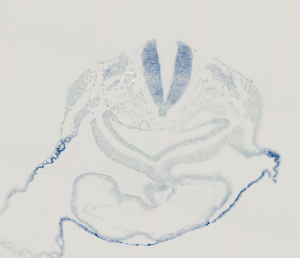
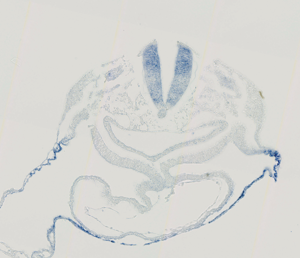
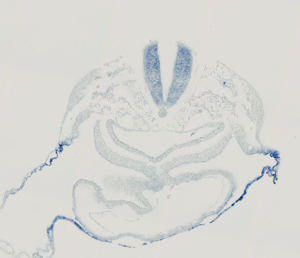
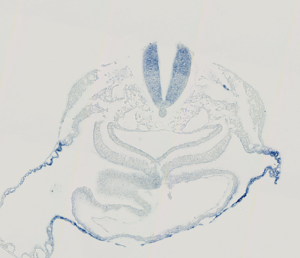
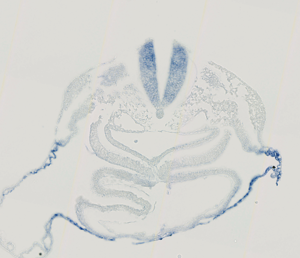
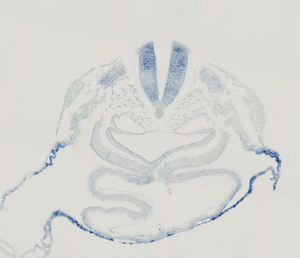
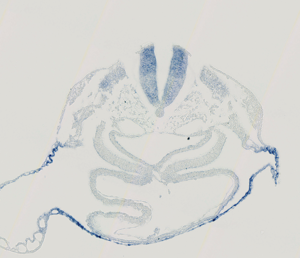
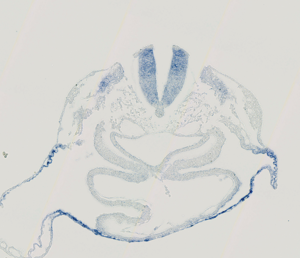
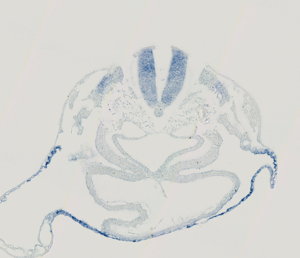


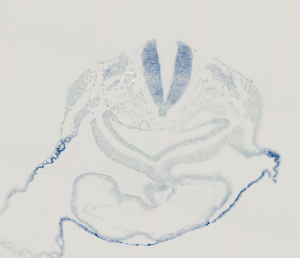
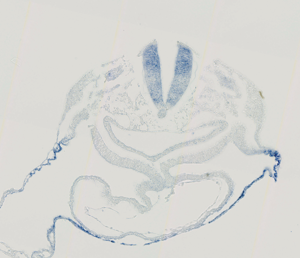
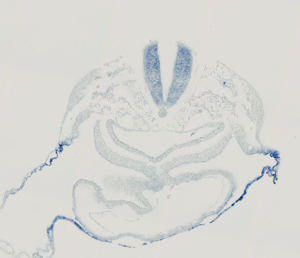
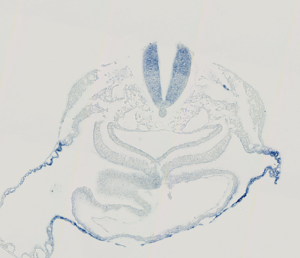
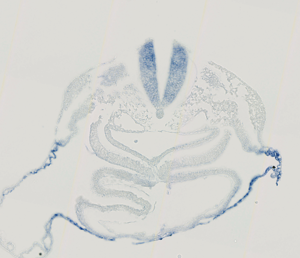
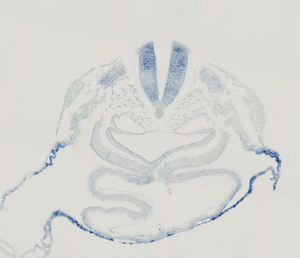
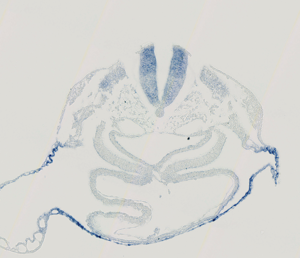
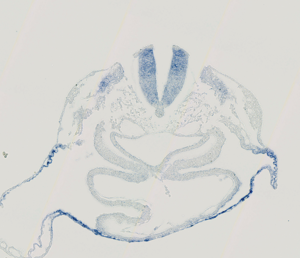
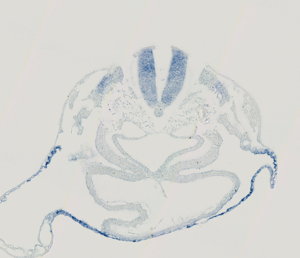

In [11]:
# Display first 9 images
image_nodes = parse('@[0:9]').find(filelist)
images = []
labels = []
for node in image_nodes:  
    image_url = study_root + '/Files/' + node.value['path']    
    with closing(urllib.request.urlopen(image_url)) as r:
        image_data = r.read()
        image = Image.open(io.BytesIO(image_data))    
        images.append(asarray(image))
        labels.append( '{} bytes'.format(node.value['size']))
ipyplot.plot_images(images,labels,img_width=300)